# Reproduction of arXiv:1506.04175

In this notebook, we'll go through [Burke et al. (2015)](http://arxiv.org/abs/1506.04175) and reproduce their findings.

In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [17]:
import emcee
import numpy as np
import pandas as pd
from itertools import izip
from scipy.stats import gamma
import matplotlib.pyplot as pl
from scipy.optimize import minimize

In [3]:
# These helper functions let us download and cache
# the catalogs from the Exoplanet Archive.
from exopop2.data import get_kois, get_stlr

## Datasets

To start, we'll download the stellar target catalog and the relevant KOI list.

In [4]:
stlr = get_stlr()

# Select G and K dwarfs.
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15

# Remove targets with missing mass estimates.
m &= np.isfinite(stlr.mass)

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 < 1000 

stlr = stlr[m]

print("Selected {0} targets after cuts".format(len(stlr)))

Selected 91446 targets after cuts


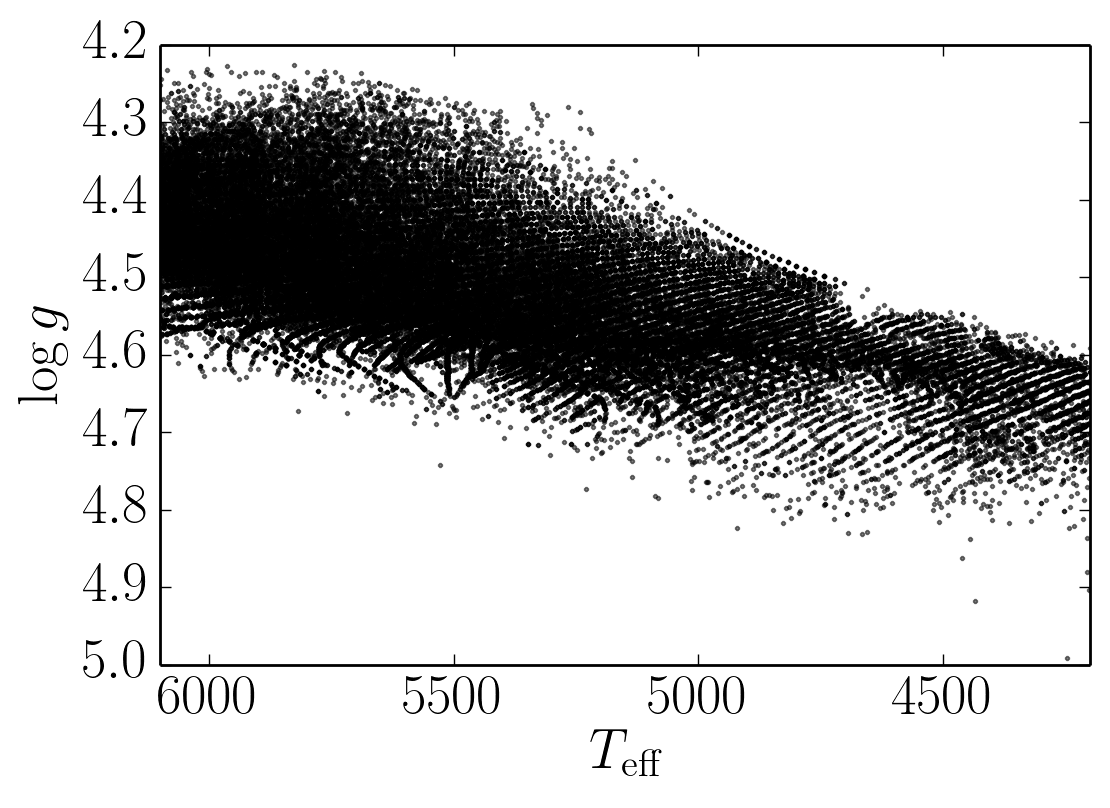

In [5]:
pl.plot(stlr.teff, stlr.logg, ".k", ms=3, alpha=0.5)
pl.xlim(6100, 4200)
pl.ylim(pl.gca().get_ylim()[::-1])  # because astronomy...
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");

In [6]:
period_rng = (50, 300)
rp_rng = (0.75, 2.5)

In [7]:
kois = get_kois()

# Join on the stellar list.
kois = pd.merge(stlr[["kepid"]], kois, on="kepid")

# Only select the KOIs in the relevant part of parameter space.
m = (kois.koi_disposition == "CANDIDATE") | (kois.koi_disposition == "CONFIRMED")
m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
m &= (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])

kois = kois[m]

print("Selected {0} KOIs after cuts".format(len(kois)))

Selected 155 KOIs after cuts


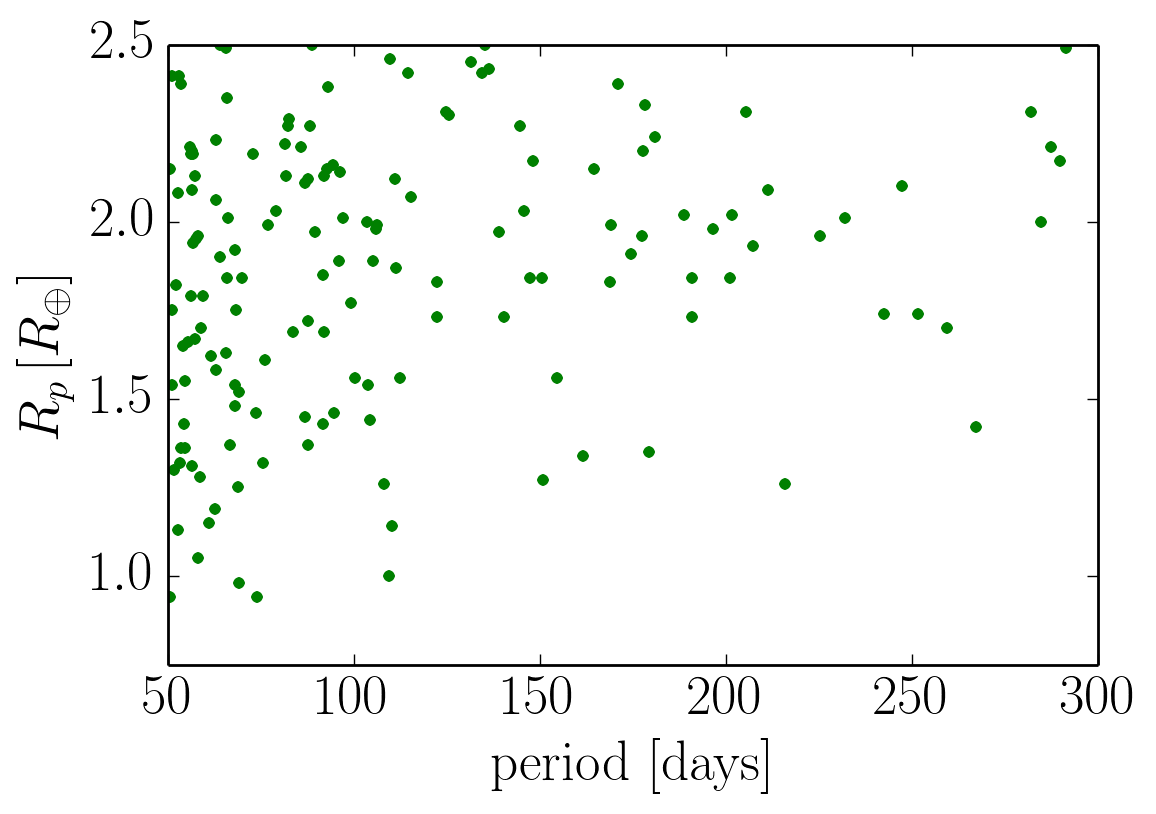

In [8]:
pl.plot(kois.koi_period, kois.koi_prad, "og", mec="none", ms=4)
pl.xlim(period_rng)
pl.ylim(rp_rng)
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");

In [9]:
def get_duration(period, aor, e):
    return 4 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    delta_max = k*k * (c + s*k)
    return 0.84 * delta_max

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
def get_snr(star, tau, k):
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)
    return get_delta(k) * 1e6 / sigma

def get_mes(star, period, rp, tau, re=0.009171):
    k = rp * re / star.radius
    snr = get_snr(star, tau, k)
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e):
    tau = get_duration(period, aor, e)
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, mesthres_vals,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    return pgam.cdf(x)

def get_pwin(star, period):
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (period < star.dataspan)
    return pw * msk

def get_pgeom(aor, e):
    return 1. / (aor * (1 - e*e)) * (aor > 1.0) + (aor < 1.0)

def get_completeness(star, period, rp, e, with_geom=True):
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

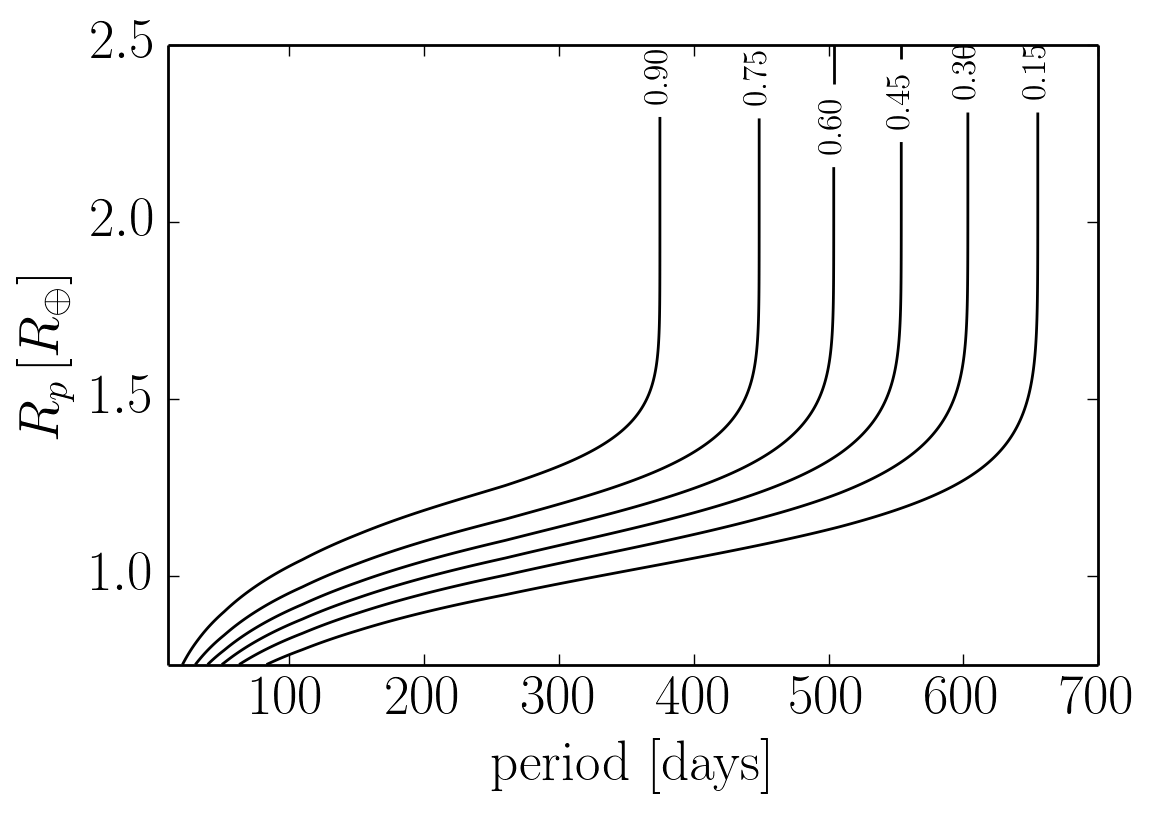

In [11]:
star = stlr[stlr.kepid == 10593626].iloc[0]

period = np.linspace(10, 700, 500)
rp = np.linspace(0.75, 2.5, 421)
X, Y = np.meshgrid(period, rp, indexing="ij")
Z = get_completeness(star, X, Y, 0.0, with_geom=False)

c = pl.contour(X, Y, Z, colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.2f") 
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");

In [12]:
# Compute the mean completeness in the range.
period = np.linspace(period_rng[0], period_rng[1], 50)
rp = np.linspace(rp_rng[0], rp_rng[1], 57)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
comp = np.zeros_like(period_grid)

for _, star in stlr.iterrows():
    comp += get_completeness(star, period_grid, rp_grid, 0.0, with_geom=True)

comp /= len(stlr)

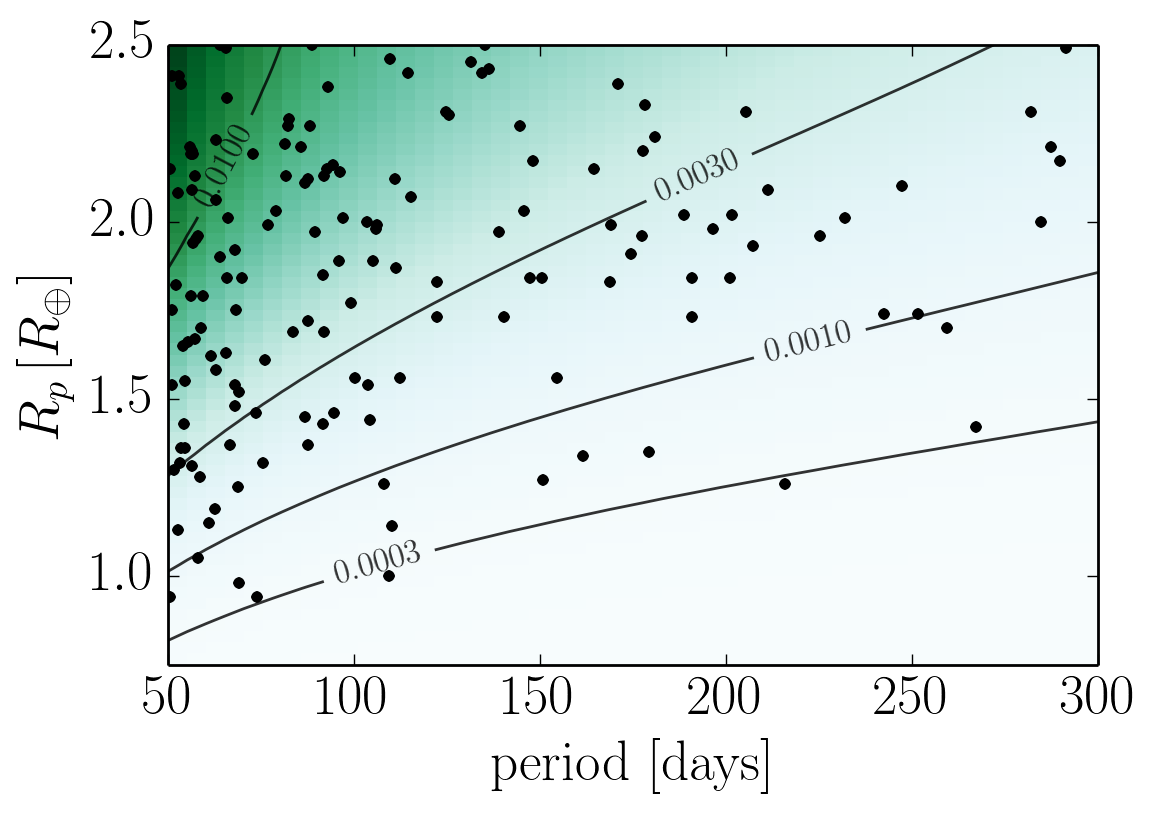

In [13]:
pl.plot(kois.koi_period, kois.koi_prad, "ok", mec="none", ms=4)

pl.pcolor(period_grid, rp_grid, comp, cmap="BuGn")
c = pl.contour(period_grid, rp_grid, comp, [0.0003, 0.001, 0.003, 0.01],
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.4f") 
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");

In [14]:
def population_model(theta, period, rp):
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(period)
    for x, rng, n in izip((period, rp), (period_rng, rp_rng),
                          (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

koi_periods = np.array(kois.koi_period)
koi_rps = np.array(kois.koi_prad)
vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, period_grid, rp_grid)
    pop *= comp
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(population_model(theta, koi_periods, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

def lnprob(theta):
    return lnlike(theta)

def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [15]:
theta_0 = np.array([np.log(0.75*len(stlr)), -0.53218, -0.5])
r = minimize(nll, theta_0, method="L-BFGS-B",
             bounds=[(None, None), (None, None), (None, None)])

In [18]:
ndim, nwalkers = len(r.x), 16
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [37]:
pos, _, _ = sampler.run_mcmc(pos, 200)
sampler.reset()
pos, _, _ = sampler.run_mcmc(pos, 2000)

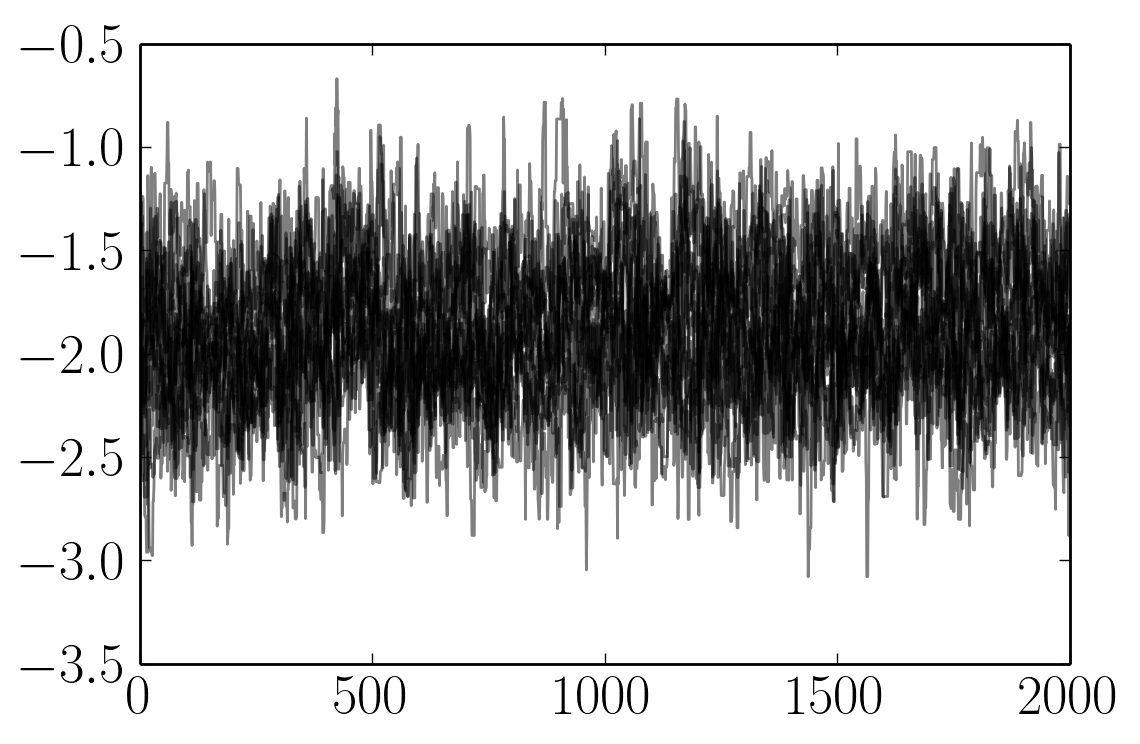

In [78]:
pl.plot(sampler.chain[:, :, 2].T, "k", alpha=0.5);

In [79]:
samps = sampler.chain[:, ::5, :]
samps = samps.reshape((-1, samps.shape[-1]))
pop = np.empty((len(samps), period_grid.shape[0], period_grid.shape[1]))
gamma_earth = np.empty((len(samps)))
for i, p in enumerate(samps):
    pop[i] = population_model(p, period_grid, rp_grid)
    gamma_earth[i] = population_model(p, 365.25, 1.0)

In [43]:
pop_comp = pop * comp[None, :, :]

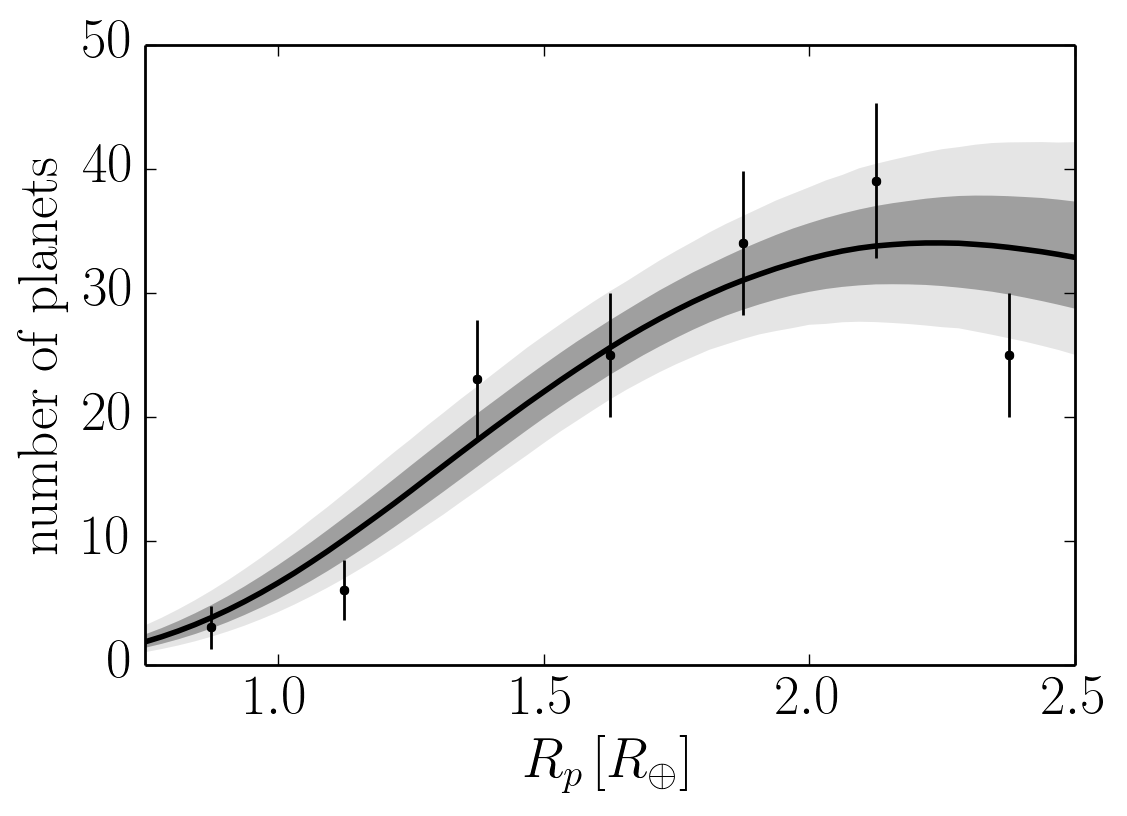

In [65]:
dx = 0.25
x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)

pop_rp = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
pop_rp = np.sum(pop_rp * np.diff(period)[None, :, None], axis=1)
a, b, c, d, e = np.percentile(pop_rp * dx, [2.5, 16, 50, 84, 97.5], axis=0)

pl.fill_between(rp, a, e, color="k", alpha=0.1, edgecolor="none")
pl.fill_between(rp, b, d, color="k", alpha=0.3, edgecolor="none")
pl.plot(rp, c, "k", lw=2)

n, _ = np.histogram(koi_rps, x)
pl.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0)
pl.xlim(rp_rng[0], rp_rng[1])
pl.xlabel("$R_p\,[R_\oplus]$")
pl.ylabel("number of planets");

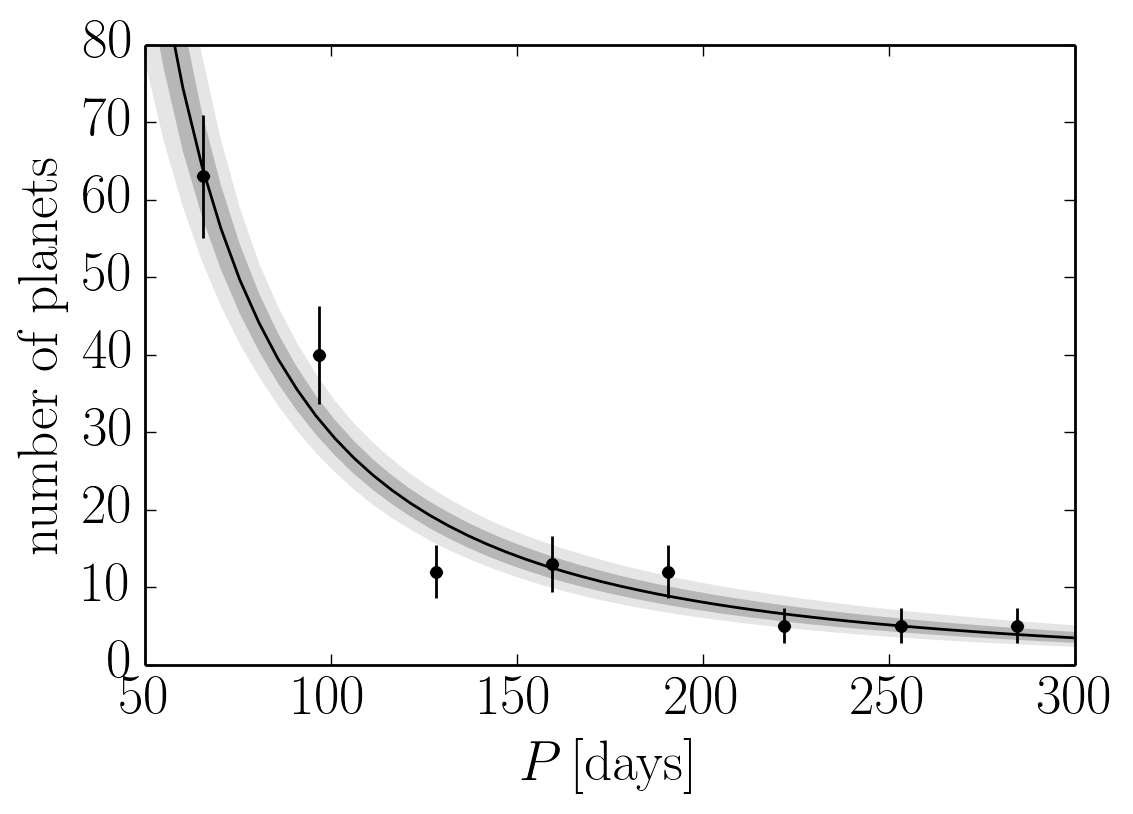

In [74]:
dx = 31.25
x = np.arange(period_rng[0], period_rng[1] + dx, dx)

pop_per = 0.5 * (pop_comp[:, :, 1:] + pop_comp[:, :, :-1])
pop_per = np.sum(pop_per * np.diff(rp)[None, None, :], axis=2)

a, b, c, d, e = np.percentile(pop_per * dx, [2.5, 16, 50, 84, 97.5], axis=0)

pl.fill_between(period, a, e, color="k", alpha=0.1, edgecolor="none")
pl.fill_between(period, b, d, color="k", alpha=0.2, edgecolor="none")
pl.plot(period, c, "k", lw=1)

n, _ = np.histogram(koi_periods, x)
pl.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", ms=8, capsize=0)
pl.xlim(period_rng[0], period_rng[1])
pl.ylim(0, 80)
pl.xlabel("$P\,[\mathrm{days}]$")
pl.ylabel("number of planets");

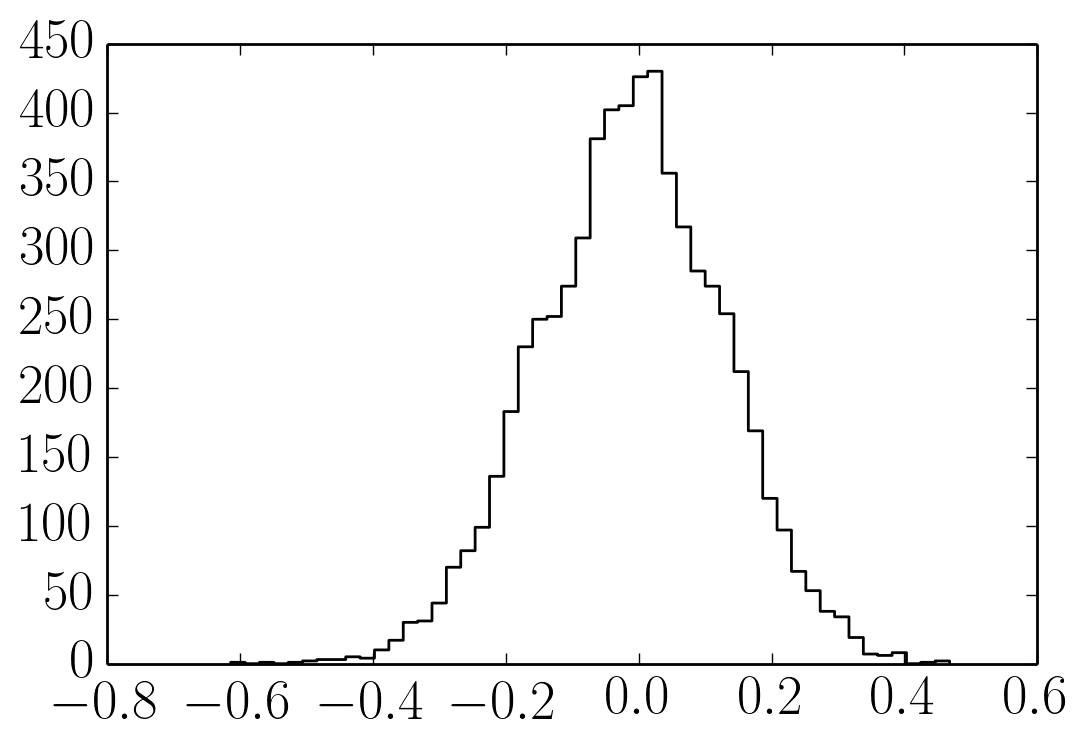

In [84]:
pl.hist(np.log10(gamma_earth / len(stlr) * 365.25), 50, histtype="step", color="k");